In [8]:
# ===================== INSTALL DEPENDENCIES =====================
!pip install -q pandas scikit-learn shap langchain langchain-community langchain-groq matplotlib seaborn


In [9]:
# ===================== IMPORTS =====================
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from langchain_groq import ChatGroq

In [10]:

# ===================== LOAD DATA =====================
df = pd.read_csv("/content/drive/MyDrive/student_data.csv")

In [11]:
# ===================== CREATE RISK LABEL =====================
def risk_label(score):
    if score < 10:
        return "High"
    elif score < 14:
        return "Medium"
    else:
        return "Low"

df["RiskLevel"] = df["G3"].apply(risk_label)

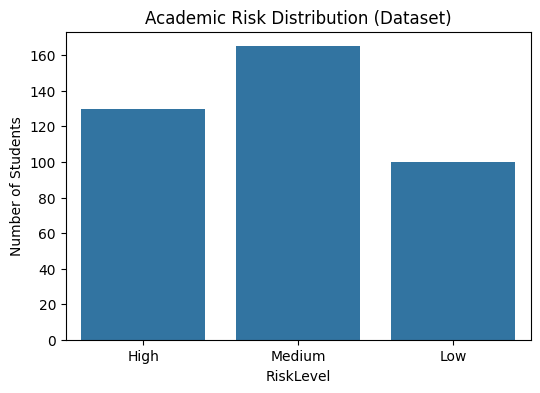

In [12]:
# ===================== GRAPH 1: RISK DISTRIBUTION =====================
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="RiskLevel", order=["High","Medium","Low"])
plt.title("Academic Risk Distribution (Dataset)")
plt.ylabel("Number of Students")
plt.show()


In [13]:
# ===================== PREPARE FEATURES =====================
X = df.drop(columns=["G3", "RiskLevel"])
y = df["RiskLevel"]
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [14]:

# ===================== TRAIN ML MODEL =====================
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [15]:
# ===================== MODEL EVALUATION =====================
y_pred = model.predict(X_test)
print("\n=== CLASSIFICATION REPORT ===\n")
print(classification_report(y_test, y_pred))


=== CLASSIFICATION REPORT ===

              precision    recall  f1-score   support

        High       0.89      0.92      0.91        26
         Low       1.00      0.65      0.79        20
      Medium       0.77      0.91      0.83        33

    accuracy                           0.85        79
   macro avg       0.89      0.83      0.84        79
weighted avg       0.87      0.85      0.85        79



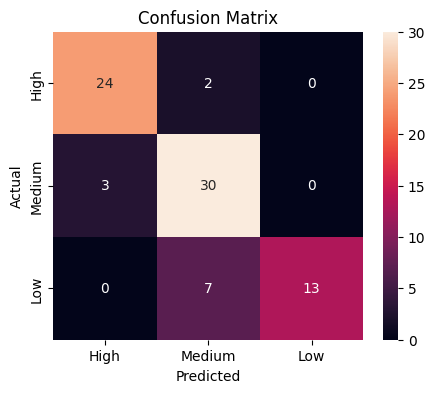

In [16]:

# ===================== GRAPH 2: CONFUSION MATRIX =====================
cm = confusion_matrix(y_test, y_pred, labels=["High","Medium","Low"])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["High","Medium","Low"],
            yticklabels=["High","Medium","Low"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


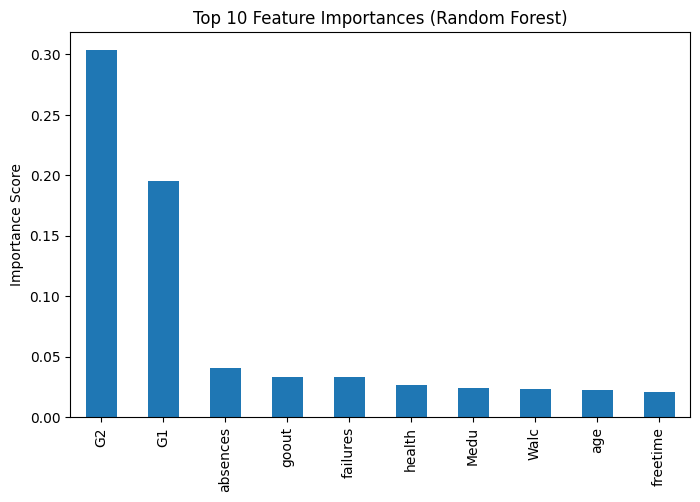

In [18]:
# ===================== GRAPH 3: FEATURE IMPORTANCE =====================
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.sort_values(ascending=False).head(10).plot(kind="bar", figsize=(8,5))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.show()



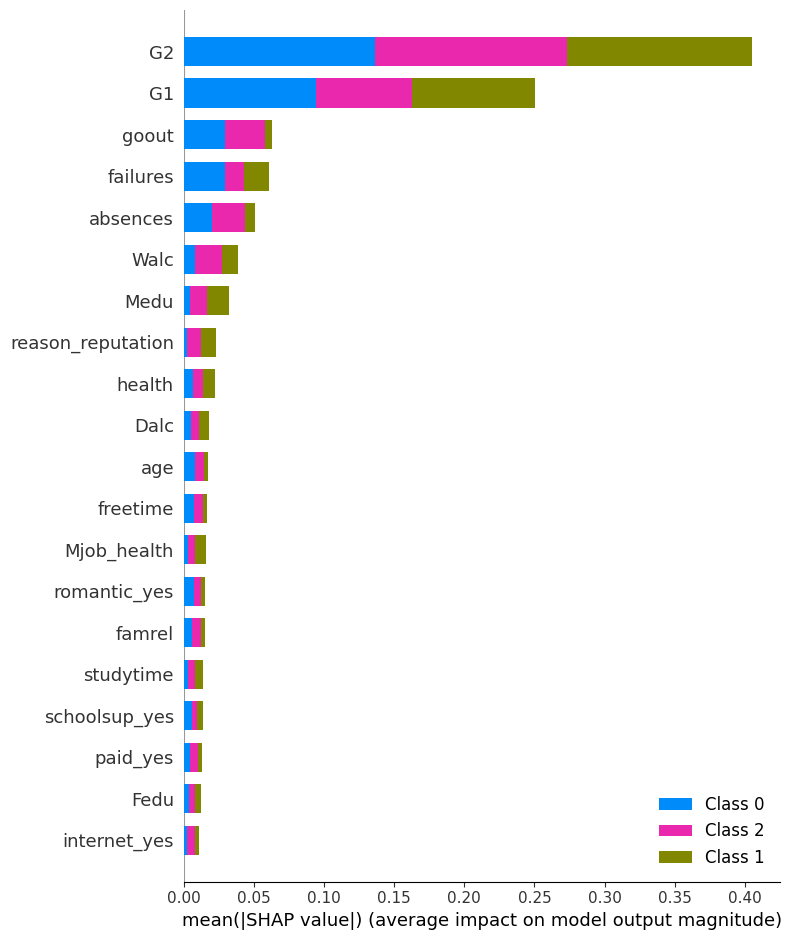

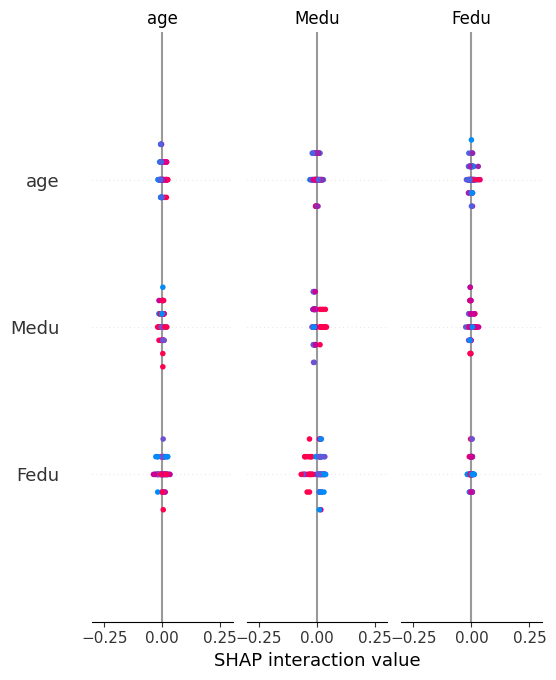

In [19]:
# ===================== SHAP EXPLANATIONS =====================
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)



In [20]:
# ===================== USER INPUT =====================
print("\nEnter Student Academic Details\n")

attendance = float(input("Attendance (%): "))
study_hours = float(input("Study hours per day (0–8): "))
assignments = float(input("Assignment completion (%): "))
participation = input("Participation (Low / Medium / High): ").strip().lower()


Enter Student Academic Details

Attendance (%): 87
Study hours per day (0–8): 4
Assignment completion (%): 80
Participation (Low / Medium / High): Medium


In [21]:
# ===================== PERFORMANCE SCORING =====================
participation_map = {"low": 40, "medium": 70, "high": 100}
participation_score = participation_map.get(participation, 40)

study_score = min((study_hours / 8) * 100, 100)

performance_score = (
    attendance * 0.30 +
    study_score * 0.25 +
    assignments * 0.25 +
    participation_score * 0.20
)


In [22]:

# ===================== FINAL RISK PREDICTION =====================
if performance_score < 50:
    final_risk = "High"
elif performance_score < 70:
    final_risk = "Medium"
else:
    final_risk = "Low"

confidence = round(performance_score / 100, 2)

print("\n=== FINAL STUDENT RESULT ===")
print("Performance Score:", round(performance_score,2))
print("Predicted Academic Risk:", final_risk)
print("Confidence Level:", confidence)





=== FINAL STUDENT RESULT ===
Performance Score: 72.6
Predicted Academic Risk: Low
Confidence Level: 0.73


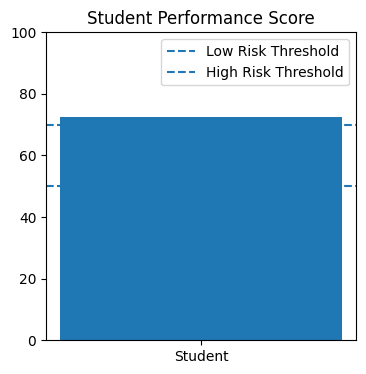

In [23]:
# ===================== GRAPH 4: PERFORMANCE SCORE =====================
plt.figure(figsize=(4,4))
plt.bar(["Student"], [performance_score])
plt.axhline(70, linestyle="--", label="Low Risk Threshold")
plt.axhline(50, linestyle="--", label="High Risk Threshold")
plt.ylim(0,100)
plt.legend()
plt.title("Student Performance Score")
plt.show()

In [24]:
# ===================== GROQ LLM =====================
GROQ_API_KEY = None
try:
    from google.colab import userdata
    GROQ_API_KEY = userdata.get("GROQ_API_KEY")
except Exception:
    pass

if not GROQ_API_KEY:
    GROQ_API_KEY = os.environ.get("GROQ_API_KEY")

if not GROQ_API_KEY:
    raise RuntimeError("GROQ_API_KEY not found. Set it in Colab secrets or as env var.")

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.4,
    groq_api_key=GROQ_API_KEY
)


In [25]:

# ===================== LLM FEEDBACK =====================
prompt = f"""
You are an academic mentor.

Student Performance Data:
Attendance: {attendance}%
Study Hours: {study_hours} hours/day
Assignment Completion: {assignments}%
Participation: {participation.capitalize()}

Calculated Performance Score: {round(performance_score,2)}
Predicted Academic Risk Level: {final_risk}
Confidence Level: {confidence}

Tasks:
1. Explain the student's academic performance clearly.
2. Explain why the risk level is {final_risk}.
3. Provide EXACTLY 3 personalized improvement steps.
4. End with encouragement.
"""

print("\n================ AI MENTOR FEEDBACK ================\n")
print(llm.invoke(prompt).content)



================ AI MENTOR FEEDBACK ================

Based on the provided data, let's break down the student's academic performance. The student has an attendance rate of 87.0%, which is relatively good but could be improved. They dedicate 4.0 hours a day to studying, which is a decent amount of time. The assignment completion rate is 80.0%, indicating that the student is generally keeping up with their work but might be struggling with some tasks. Participation in class is medium, suggesting that the student could be more engaged in discussions and activities.

The calculated performance score is 72.6, which is a decent score but indicates there's room for improvement. Given this score and other factors, the predicted academic risk level is Low, with a confidence level of 0.73. The risk level is Low because, despite areas for improvement, the student's overall performance suggests they are managing their academic responsibilities fairly well. The attendance, study hours, and assign